In [86]:
import sys, glob, os
import numpy as np
import scipy as sp
import pandas as pd
from csv import reader, writer
import joblib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Input, Dense, Dropout, Conv1D, Conv1DTranspose, BatchNormalization
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [178]:
cwd = '/content/drive/MyDrive/Daylight Autonomy/'

In [78]:
df = pd.read_csv("/content/drive/MyDrive/Daylight Autonomy/output_v0.9_singleOutput_FullOutput_dummy.txt",
                 sep = ";",names=range(500))
df.fillna(value=0)

In [19]:
headers = list(df.iloc[0,0:9])

data = df.iloc[:,10:18].copy()
data.columns = headers[0:8]

target = df[18].copy()
target.columns = headers[-1]

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=45)

In [116]:
class DNN():
    def __init__(self, node, layer, outpt):
        self.node = node
        self.layer = layer

        self.model = Sequential()

        for i in range(layer):
            self.model.add(Dense(node, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
            # model.add(BatchNormalization())
            self.model.add(Activation('relu'))
            # model.add(AlphaDropout(0.2))

        self.model.add(Dense(outpt, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=0.0005, 
                                    beta_1=0.9, beta_2=0.999, amsgrad=True)

        self.model.compile(optimizer=optimizer, 
                          loss='mse')

        self.es = EarlyStopping(monitor='val_loss',
                               patience=300,
                               verbose=1)

        self.checkpoint_filepath = 'DNN.ckpt'.format(node, layer)

        self.mc = ModelCheckpoint(filepath = self.checkpoint_filepath,
                                 save_weights_only=True, 
                                 monitor='val_loss',
                                 save_best_only=True)
    def fit(self, X_train, y_train, X_val, y_val, epoch=3000):
        self.hist = self.model.fit(X_train, y_train, 
                                  epochs=epoch, 
                                  batch_size=1024, 
                                  verbose=2, 
                                  validation_data = (X_val, y_val),
                                  callbacks=[self.es, self.mc]);

    def visualize(self):
        loss = self.hist.history['loss']
        val_loss = self.hist.history['val_loss']

        fig = plt.figure()
        plt.plot(range(len(loss)), loss, label='loss')
        plt.plot(range(len(val_loss)), val_loss, label='val_loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

    def predict(self, X):
        self.model.load_weights(self.checkpoint_filepath)
        return self.model.predict(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)        
        return np.sqrt(mean_squared_error(y_test,y_pred))
        
    def print_eval(self, X_test, y_test):
        rmse = self.evaluate(X_test, y_test)
        
        print("Min RMSE: {:.2f}, Max RMSE: {:.2f}, Average RMSE: {:.2f}".format(min(rmse), max(rmse), np.mean(rmse)))

    def plot_eval(self, X_test, y_test):
        rmse, eep = self.evaluate(X_test, y_test)

        fig, axs = plt.subplots(figsize=(9,4));
        axs[0].hist(rmse, bins=100);
        axs[0].set_title('RMSE');

        # plt.savefig(os.path.join(cwd,'figures/hist_DNN_{}-{}.png'.format(self.node, self.layer)))

    def save(self, cwd, filename):
        json = os.path.join(cwd, 'models/{}_{}-{}.json'.format(filename, self.node, self.layer))
        hdf5 = os.path.join(cwd, 'models/{}_{}-{}.h5'.format(filename, self.node, self.layer))

        model_json = self.model.to_json()
        with open(json,'w') as json_file:
            json_file.write(model_json)
        self.model.save_weights(hdf5)

In [117]:
dnn = DNN(20, 3, 1)

In [118]:
dnn.fit(X_train, y_train, X_val, y_val, epoch=100)

Epoch 1/100
2/2 - 1s - loss: 3.6803 - val_loss: 2.3789
Epoch 2/100
2/2 - 0s - loss: 1.9589 - val_loss: 1.3826
Epoch 3/100
2/2 - 0s - loss: 1.2535 - val_loss: 1.2436
Epoch 4/100
2/2 - 0s - loss: 1.2572 - val_loss: 1.4015
Epoch 5/100
2/2 - 0s - loss: 1.4177 - val_loss: 1.4137
Epoch 6/100
2/2 - 0s - loss: 1.3887 - val_loss: 1.2340
Epoch 7/100
2/2 - 0s - loss: 1.1662 - val_loss: 0.9822
Epoch 8/100
2/2 - 0s - loss: 0.9017 - val_loss: 0.7909
Epoch 9/100
2/2 - 0s - loss: 0.7112 - val_loss: 0.7105
Epoch 10/100
2/2 - 0s - loss: 0.6372 - val_loss: 0.7130
Epoch 11/100
2/2 - 0s - loss: 0.6390 - val_loss: 0.7306
Epoch 12/100
2/2 - 0s - loss: 0.6452 - val_loss: 0.7013
Epoch 13/100
2/2 - 0s - loss: 0.6083 - val_loss: 0.6184
Epoch 14/100
2/2 - 0s - loss: 0.5281 - val_loss: 0.5203
Epoch 15/100
2/2 - 0s - loss: 0.4479 - val_loss: 0.4524
Epoch 16/100
2/2 - 0s - loss: 0.3993 - val_loss: 0.4254
Epoch 17/100
2/2 - 0s - loss: 0.3884 - val_loss: 0.4185
Epoch 18/100
2/2 - 0s - loss: 0.3866 - val_loss: 0.4060
E

In [119]:
dnn.evaluate(X_test, y_test)

0.11041171219570035

In [ ]:
results = []

for node in range(10, 50, 10):
    for layer in range(1, 5):
        DA_dnn = DNN(node, layer, 1)
        DA_dnn.fit(X_train, y_train, X_val, y_val, epoch=500)
        rmse = DA_dnn.evaluate(X_test, y_test)

        results.append([node, layer, np.mean(rmse)])

In [126]:
r = pd.DataFrame(results, columns=['Nodes', 'Layers', 'RMSE'])

In [182]:
r

,Nodes,Layers,RMSE
0,10,1,0.275812
1,10,2,0.182341
2,10,3,0.034595
3,10,4,0.019637
4,20,1,0.126160
5,20,2,0.032264
6,20,3,0.027332
7,20,4,0.035417
8,30,1,0.098517
9,30,2,0.043634


In [132]:
r.loc[r.RMSE == r.RMSE.min()]

,Nodes,Layers,RMSE
3,10,4,0.019637


In [133]:
DA_dnn = DNN(10, 4, 1)
DA_dnn.fit(X_train, y_train, X_val, y_val, epoch=3000)
rmse = DA_dnn.evaluate(X_test, y_test)

Streaming output truncated to the last 5000 lines.
Epoch 501/3000
2/2 - 0s - loss: 0.0431 - val_loss: 0.0436
Epoch 502/3000
2/2 - 0s - loss: 0.0431 - val_loss: 0.0435
Epoch 503/3000
2/2 - 0s - loss: 0.0430 - val_loss: 0.0434
Epoch 504/3000
2/2 - 0s - loss: 0.0429 - val_loss: 0.0433
Epoch 505/3000
2/2 - 0s - loss: 0.0428 - val_loss: 0.0433
Epoch 506/3000
2/2 - 0s - loss: 0.0428 - val_loss: 0.0432
Epoch 507/3000
2/2 - 0s - loss: 0.0427 - val_loss: 0.0431
Epoch 508/3000
2/2 - 0s - loss: 0.0426 - val_loss: 0.0431
Epoch 509/3000
2/2 - 0s - loss: 0.0426 - val_loss: 0.0430
Epoch 510/3000
2/2 - 0s - loss: 0.0425 - val_loss: 0.0429
Epoch 511/3000
2/2 - 0s - loss: 0.0424 - val_loss: 0.0428
Epoch 512/3000
2/2 - 0s - loss: 0.0423 - val_loss: 0.0428
Epoch 513/3000
2/2 - 0s - loss: 0.0423 - val_loss: 0.0427
Epoch 514/3000
2/2 - 0s - loss: 0.0422 - val_loss: 0.0426
Epoch 515/3000
2/2 - 0s - loss: 0.0421 - val_loss: 0.0425
Epoch 516/3000
2/2 - 0s - loss: 0.0421 - val_loss: 0.0425
Epoch 517/3000
2/2 - 

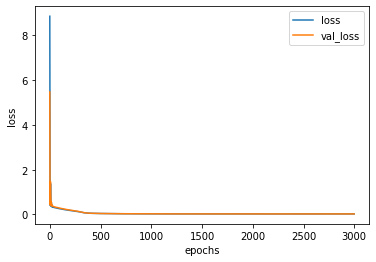

In [177]:
DA_dnn.visualize()

In [136]:
y_pred = DA_dnn.predict(X_test)

In [184]:
j = 35

print(X_test.iloc[j])
print("Simulated: {}".format(y_test.iloc[j]))
print("Predicted: {}".format(y_pred[j][0]))

SideA            2.000000
SideB           10.000000
SideC            4.000000
SideD           10.198039
WindowWidth      1.200000
WindowLength     1.843909
Orientation      0.000000
Area            30.000000
Name: 2027, dtype: float64
Simulated: 0.65625
Predicted: 0.676887571811676


In [169]:
test_case = np.array([4,9,5,9.5,2.3,3.4,0,45])

In [175]:
DA_dnn.predict(np.expand_dims(test_case, axis=0))[0][0]

0.6239396

In [180]:
DA_dnn.save(cwd, 'DA_dnn')